# Milestone 3: Alzheimer's Group 16


#### Daniel Graziano, Daniel Molina Hurtado, Esmail Fadae, Paxton Maeder-York

Our strategy is to look at all the supporting datasets, pull out columns that are relevant and join based on patient ID (RID), only saving test rows that occured post diagnosis.

## Introduction

In this project, we are going to work with the vast amount of information provided by the Alzheimer’s Disease Neuroimaging Initiative (ADNI). This data has been colected by researchers at more than 60 sites in the US and Canada working with thousands of participants between the ages of 55 and 90. Participants can start the study with normal cognitive function, mild cognitive impairment (MCI) or Alzheimer's Desease (AD). The project is divided in several phases in time: ADNI1 (2004-2009), ADNIGO(2009-2001), ADNI2(2011-2016) and ADNI3(2016-2021). The study collects different types of data such as demographics, family history, genetics, neuropsycologichal tests, imaging or biomarkers.

Our initial goal in this project will be to determine the most effective biomarkers and neuropsychological tests in order to predict Alzheimer's disease. If time permits we will also focus on summary imaging data but that is out of scope for now. 

We will start by exploring and putting together data from different datasets in different areas, cleaning it and preparing it for modeling and making predictions in further stages of the project.

#### Libraries and Imports

In [1]:
#Basic Imports
import numpy as np
import pandas as pd
import math
import requests

#Preprocessing Imports
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing.imputation import Imputer
from sklearn.preprocessing import StandardScaler

#Model Imports
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

#Plotting Imports
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

#Other Imports
from scipy.special import gamma
from IPython.display import display
from typing import List, Tuple, Dict
from io import BytesIO


/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:

#Import some data from our shared google drive folder

#file_id comes from the end of the shareable link of the file from google drive
#it is a set of alphanumeric characters after the '/d/ tag in the share URL
#or the 'id' label, see example below
#https://drive.google.com/open?id=1FSjJjpS1Ob_BEbshyl9dXb1FFmCnZrHE
#have to decode the bytes before it can be read by pandas into df

def read_gdrive_data(file_id):
  response = requests.get('https://drive.google.com/uc?export=download&id=%s' % file_id)
  df = pd.read_csv(BytesIO(response.content),na_values='-4')
  return df

## Section 1: Dataset Investigations

ADNI project collected and is collecting an enormous amount of data that is provided in many scattered csv files and with quite cryptic labels and codes. This together with the lack of knowledge in the field can be overwhelming and challenging at first. In this section we are going to explore different types of data and determine thier relevance. 


### Uwnpsych Dataset

In [3]:
uwnpsych_file_id='1E3GUw64INaCmS8ld6H2G8HtND_dyZg6S'

uwnpsych_df=read_gdrive_data(uwnpsych_file_id)

display(uwnpsych_df.describe())
display(uwnpsych_df.head())

,RID,ADNI_MEM,ADNI_EF
count,9207.000000,9206.000000,9112.000000
mean,2264.376018,0.220645,0.165758
std,1878.194689,1.045454,1.055390
min,2.000000,-2.899000,-3.228000
25%,621.000000,-0.510000,-0.481000
50%,1283.000000,0.261000,0.234000
75%,4360.000000,0.955750,0.907000
max,6072.000000,3.328000,3.063000


,RID,VISCODE,VISCODE2,USERDATE,EXAMDATE,PHASE,ADNI_MEM,ADNI_EF,update_stamp
0,2,m06,m06,2006-03-07,2006-03-06,ADNI1,0.585,-0.197,2017-10-30 10:19:49.0
1,2,m36,m36,2008-08-27,2008-08-27,ADNI1,0.403,-0.008,2017-10-30 10:19:49.0
2,2,bl,bl,2005-09-09,2005-09-08,ADNI1,0.503,-0.060,2017-10-30 10:19:49.0
3,2,v21,m96,2013-09-11,2013-09-09,ADNI2,0.325,-0.726,2017-10-30 10:19:49.0
4,2,v06,m72,2011-09-20,2011-09-19,ADNI2,0.349,0.304,2017-10-30 10:19:49.0


In [4]:
uwnpsych_df['VISCODE'].value_counts()

bl      1355
m06      898
v11      887
m24      814
m12      744
v05      718
v21      660
m36      467
v31      453
v03      418
v41      381
v06      366
m18      329
m48      232
sc       158
v51       95
m60       76
m72       74
m84       31
m132      23
m120      18
m108       7
m96        3
Name: VISCODE, dtype: int64

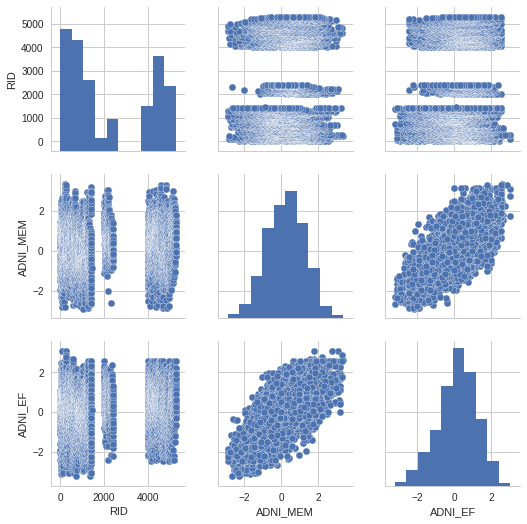

In [5]:
sns.pairplot(data=uwnpsych_df.dropna())

This dataset is a physcological examination dataset.  Seems directly relevant to our predictive modelling.

###Modhach Dataset

In [6]:
modhach_df_file_id='1iDWNCprJ3e_LU4fegAXNyvWo9pJOYhnk'

modhach_df=read_gdrive_data(modhach_df_file_id)
display(modhach_df.describe())
display(modhach_df.head())

,ID,RID,SITEID,HMONSET,HMSTEPWS,HMSOMATC,HMEMOTIO,HMHYPERT,HMSTROKE,HMNEURSM,HMNEURSG,HMSCORE
count,2554.000000,2554.000000,2554.000000,2553.000000,2553.000000,2553.000000,2553.000000,2552.000000,2552.000000,2551.000000,2552.000000,2552.000000
mean,1442.274863,2718.639389,42.998042,0.007051,0.017235,0.031336,0.014101,0.466301,0.030564,0.029008,0.043103,0.638715
std,2434.155022,1992.530324,35.833684,0.118562,0.130170,0.174257,0.117931,0.498961,0.245393,0.239160,0.290486,0.778709
min,6.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,434.000000,791.250000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1044.000000,2227.500000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1681.500000,4622.750000,56.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,21921.000000,6130.000000,127.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,7.000000


,Phase,ID,RID,SITEID,VISCODE,VISCODE2,USERDATE,USERDATE2,EXAMDATE,HMONSET,HMSTEPWS,HMSOMATC,HMEMOTIO,HMHYPERT,HMSTROKE,HMNEURSM,HMNEURSG,HMSCORE,update_stamp
0,ADNI1,6,2,107,sc,sc,2005-08-17,NaN,2005-08-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005-08-17 00:00:00.0
1,ADNI1,8,3,107,sc,sc,2005-08-18,NaN,2005-08-18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2005-08-18 00:00:00.0
2,ADNI1,10,4,10,sc,sc,2005-08-18,NaN,2005-08-18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2005-08-18 00:00:00.0
3,ADNI1,12,5,107,sc,sc,2005-08-23,NaN,2005-08-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005-08-23 00:00:00.0
4,ADNI1,14,7,10,sc,sc,2005-08-26,NaN,2005-08-25,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2005-08-26 00:00:00.0


In [0]:
#sns.pairplot(data=modhach_df.dropna())

As we can see, these are all categorical data points that represent the results for the Modified Hachinski tests performed on the patients. It seems the best approach would be to break apart the categories using one-hot encoding. There aren't that many categories, so this shouldn't add a crazy number of features.

Background: Vascular causes and factors remain the most significant preventable component of cognitive disorders of elderly individuals. The Hachinski Ischemic Score (HIS) is the questionnaire most commonly used for diagnosis of vascular dementia.

### Medical History Dataset

In [8]:
medhist_df_file_id = "11pMQ1ye7kPKqZeqy5CistUeTR218lA7P"
medhist_df=read_gdrive_data(medhist_df_file_id)
display(medhist_df.describe())
display(medhist_df.head())

,ID,RID,SITEID,MHSOURCE,MHPSYCH,MH2NEURL,MH3HEAD,MH4CARD,MH5RESP,MH6HEPAT,MH7DERM,MH8MUSCL,MH9ENDO,MH10GAST,MH11HEMA,MH12RENA,MH13ALLE,MH14ALCH,MH14AALCH,MH14BALCH,MH14CALCH,MH15DRUG,MH15ADRUG,MH15BDRUG,MH16SMOK,MH16ASMOK,MH16BSMOK,MH16CSMOK,MH17MALI,MH18SURG,MH19OTHR
count,3082.000000,3082.000000,3082.000000,3082.000000,3082.000000,3082.000000,3082.000000,3082.000000,3082.000000,3082.000000,3082.000000,3082.000000,3082.000000,3082.000000,3081.000000,3082.000000,3082.000000,3082.000000,93.000000,93.000000,93.000000,3082.000000,18.000000,18.000000,3082.000000,786.000000,786.000000,725.000000,3082.000000,3082.000000,3082.000000
mean,1206.264763,2260.406879,40.108047,1.006814,0.350746,0.314406,0.628164,0.664179,0.222258,0.038936,0.318624,0.669371,0.423751,0.445165,0.096073,0.433809,0.419533,0.044127,6.344086,16.408602,21.059140,0.009734,13.666667,28.055556,0.398443,1.247455,21.690840,31.614621,0.260221,0.748540,0.213822
std,794.241191,1844.383869,33.750103,0.082277,0.477281,0.464354,0.483373,0.472353,0.415831,0.193473,0.466019,0.470516,0.494232,0.497065,0.294739,0.495680,0.493563,0.205411,4.935441,10.992326,13.423869,0.098195,13.495097,15.734833,0.489657,1.221224,14.188332,14.070471,0.438826,0.433923,0.410069
min,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.100000,0.000000,0.000000,0.000000
25%,522.500000,669.250000,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,7.000000,7.000000,0.000000,3.500000,17.750000,0.000000,0.500000,10.000000,21.000000,0.000000,0.000000,0.000000
50%,1086.000000,1337.500000,33.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,15.000000,24.000000,0.000000,10.000000,31.000000,0.000000,1.000000,20.000000,32.000000,0.000000,1.000000,0.000000
75%,1857.500000,4356.750000,50.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,8.000000,25.000000,31.000000,0.000000,19.500000,40.000000,1.000000,1.500000,30.000000,42.000000,1.000000,1.000000,0.000000
max,2930.000000,5296.000000,127.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,25.000000,51.000000,46.000000,1.000000,40.000000,50.000000,1.000000,10.000000,66.000000,68.000000,1.000000,1.000000,1.000000


,Phase,ID,RID,SITEID,VISCODE,VISCODE2,USERDATE,USERDATE2,EXAMDATE,MHSOURCE,MHPSYCH,MH2NEURL,MH3HEAD,MH4CARD,MH5RESP,MH6HEPAT,MH7DERM,MH8MUSCL,MH9ENDO,MH10GAST,MH11HEMA,MH12RENA,MH13ALLE,MH14ALCH,MH14AALCH,MH14BALCH,MH14CALCH,MH15DRUG,MH15ADRUG,MH15BDRUG,MH16SMOK,MH16ASMOK,MH16BSMOK,MH16CSMOK,MH17MALI,MH18SURG,MH19OTHR,MHCOMMEN,update_stamp
0,ADNI1,8,2,107,sc,sc,2005-08-17,NaN,2005-08-17,1,0,0,1,0,0,0,0,0,1,0,0.0,0,0,0,NaN,NaN,NaN,0,NaN,NaN,0,NaN,NaN,NaN,0,0,0,NaN,2005-08-17 00:00:00.0
1,ADNI1,10,1,10,f,f,2005-08-18,NaN,2005-08-18,1,0,0,1,0,0,1,0,0,0,0,0.0,0,1,0,NaN,NaN,NaN,0,NaN,NaN,0,NaN,NaN,NaN,0,0,1,NaN,2005-08-18 00:00:00.0
2,ADNI1,12,3,107,sc,sc,2005-08-18,NaN,2005-08-18,1,0,0,1,1,0,0,0,1,1,0,0.0,1,0,0,NaN,NaN,NaN,0,NaN,NaN,1,NaN,NaN,NaN,1,1,0,NaN,2005-08-18 00:00:00.0
3,ADNI1,14,4,10,sc,sc,2005-08-18,NaN,2005-08-18,1,0,0,0,1,0,0,0,1,0,0,0.0,1,0,0,NaN,NaN,NaN,0,NaN,NaN,1,NaN,NaN,NaN,0,1,0,NaN,2005-08-18 00:00:00.0
4,ADNI1,16,5,107,sc,sc,2005-08-23,NaN,2005-08-23,1,0,0,1,0,0,0,1,0,0,1,0.0,1,0,0,NaN,NaN,NaN,0,NaN,NaN,1,NaN,NaN,NaN,0,1,0,NaN,2005-08-23 00:00:00.0


In [0]:
#sns.pairplot(data=medhist_df.dropna())

In [10]:
medhist_stripped_df = medhist_df[['RID','EXAMDATE','MHSOURCE','MHPSYCH','MH2NEURL','MH3HEAD','MH4CARD','MH5RESP','MH6HEPAT','MH7DERM','MH8MUSCL','MH9ENDO','MH10GAST','MH12RENA','MH13ALLE','MH14ALCH','MH15DRUG','MH16SMOK','MH17MALI','MH18SURG','MH19OTHR']]  
medhist_stripped_df.head()

,RID,EXAMDATE,MHSOURCE,MHPSYCH,MH2NEURL,MH3HEAD,MH4CARD,MH5RESP,MH6HEPAT,MH7DERM,MH8MUSCL,MH9ENDO,MH10GAST,MH12RENA,MH13ALLE,MH14ALCH,MH15DRUG,MH16SMOK,MH17MALI,MH18SURG,MH19OTHR
0,2,2005-08-17,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1,2005-08-18,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
2,3,2005-08-18,1,0,0,1,1,0,0,0,1,1,0,1,0,0,0,1,1,1,0
3,4,2005-08-18,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0
4,5,2005-08-23,1,0,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,1,0


In [0]:
medhist_stripped_df.to_csv('medhist_stripped.csv')

This data set is already someone One-Hot-Encoded for us and has useful data with some columns that are missing most of their entries.  To make this compatible with our overall data merge, I have pulled the columns that will be relevant, the RID to join on, and the Exam date to compare to our DX date.

### Physical Dataset

In [12]:
physical_df_file_id = "1mRhCaMhWbn6PFWVBGcmMVwbNG_SOHimY"
physical_df=read_gdrive_data(physical_df_file_id)
display(physical_df.describe())
display(physical_df.head())

,ID,RID,SITEID,PXGENAPP,PXHEADEY,PXNECK,PXCHEST,PXHEART,PXABDOM,PXEXTREM,PXPERIPH,PXSKIN,PXMUSCUL,PXBACK,PXOTHER,PXABNORM
count,2781.000000,2781.000000,2781.000000,2764.000000,2764.000000,2764.000000,2763.000000,2763.000000,2761.000000,2764.000000,2764.000000,2763.000000,2763.000000,1630.000000,2644.000000,2781.000000
mean,1376.294858,2583.713772,41.638619,1.022431,1.199711,1.017366,1.027868,1.086500,1.063383,1.092619,1.053184,1.172638,1.149475,1.065644,0.996974,1.009709
std,2265.902743,1990.957379,34.917105,0.155266,0.402561,0.138717,0.171096,0.284989,0.248115,0.293672,0.229227,0.380865,0.359654,0.247735,0.236617,0.098071
min,6.000000,2.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,1.000000
25%,474.000000,734.000000,15.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,954.000000,2075.000000,33.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1646.000000,4579.000000,55.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,21719.000000,6122.000000,127.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


,Phase,ID,RID,SITEID,VISCODE,VISCODE2,USERDATE,USERDATE2,EXAMDATE,PXGENAPP,PXGENDES,PXHEADEY,PXHEADDE,PXNECK,PXNECDES,PXCHEST,PXCHEDES,PXHEART,PXHEADES,PXABDOM,PXABDDES,PXEXTREM,PXEDEMA,PXEDEDES,PXPERIPH,PXPERDES,PXSKIN,PXSKIDES,PXMUSCUL,PXMUSDES,PXBACK,PXBACKDES,PXOTHER,PXOTRCOM,PXGENCOM,PXABNORM,update_stamp
0,ADNI1,6,2,107,sc,sc,2005-08-17,NaN,2005-08-17,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,2.0,"R hand birth defect, fingers not functional",NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,stacy schneider GNP,1,2005-08-17 00:00:00.0
1,ADNI1,8,3,107,sc,sc,2005-08-18,NaN,2005-08-18,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,stacy schneider GNP,1,2005-08-18 00:00:00.0
2,ADNI1,10,4,10,sc,sc,2005-08-18,NaN,2005-08-18,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1,2005-08-18 00:00:00.0
3,ADNI1,12,5,107,sc,sc,2005-08-23,NaN,2005-08-23,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,2.0,II/IV systolic murmur,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1,2005-08-23 00:00:00.0
4,ADNI1,14,7,10,sc,sc,2005-08-25,NaN,2005-08-25,1.0,NaN,2.0,lest eyes ptosis pal decrease b/l hearing,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,+1 edema B/L,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1,2005-08-25 00:00:00.0


Given the unstandardized nature and the low anticipated predicted power of this dataset, we have chosen not to include it in our first run of EDA.

### Summary
Having reviewed the individual pulled datasets, we are now going to go back to the foundational dataset and create our own merge of the predictors based on research into their relevance.

## Section 2: Dataset Merge

As recommended by one of the ADNI resources, we are going to start merging 3 important datasets: the diagnosis datasets, the ARM dataset and the registry dataset.

To do this we are going to load the diagnosis data set in which we have different information depending on the phase of the study. Remember that ADNI data is divided in 4 phases: ADNI1, ADNIGO, ADNI2, ADNI3. For the diagnosis dataset these are the relevant diagnois variables depending on the phase:

ADNI1:

- DXCURREN: 1=NL (Normal), 2=MCI (Mild Cognitive Impairment), 3=AD (Alzheimer's disease)
- DXCONV: 0=No, 1=Yes-Conversion, 2=Yes-Reversion
- DXREV: 1=MCI to Normal, 2=AD to MCI, 3=AD to Normal
- DXCONTYP: 1=Normal to MCI, 2=Normal to AD, 3=MCI to AD

ADNIGO/2/3:
- DXCHANGE: 1=Stable:NL to NL, 2=Stable:MCI to MCI, 3=Stable:AD to AD, 4=Conv:NL to MCI, 5=Conv:MCI to AD, 6=Conv:NL to AD, 7=Rev:MCI to NL, 8=Rev:AD to MCI, 9=Rev:AD to NL

In order to have the same diagnosis variable, we are going to convert the ADNI1 style data to ADNIGO/2/3 data. In order to do that we are going to follow the steps recommended by ADNI resources: http://adni.loni.usc.edu/wp-content/uploads/2012/08/slide_data_training_part2_reduced-size.pdf

In [13]:
# dx_df = pd.read_csv('data/DXSUM_PDXCONV_ADNIALL.csv')
dx_df = read_gdrive_data('1kFSq18g-iqGwPzSxld30RbJy94FSa5y3')
dx_df.columns

Index(['Phase', 'ID', 'RID', 'SITEID', 'VISCODE', 'VISCODE2', 'USERDATE', 'USERDATE2', 'EXAMDATE', 'DXCHANGE', 'DXCURREN', 'DXCONV', 'DXCONTYP', 'DXREV', 'DXNORM', 'DXNODEP', 'DXMCI', 'DXMDES', 'DXMPTR1', 'DXMPTR2', 'DXMPTR3', 'DXMPTR4', 'DXMPTR5', 'DXMPTR6', 'DXMDUE', 'DXMOTHET', 'DXMOTHSP', 'DXDSEV', 'DXDDUE', 'DXAD', 'DXADES', 'DXAPP', 'DXAPROB', 'DXAMETASP', 'DXAOTHRSP', 'DXAPOSS', 'DXAATYSP', 'DXAMETSP', 'DXAOTHSP', 'DXPARK', 'DXPARKSP', 'DXPDES', 'DXPCOG', 'DXPATYP', 'DXPOTHSP', 'DXDEP', 'DXDEPSP', 'DXOTHDEM', 'DXODES', 'DXOOTHSP', 'DXCONFID', 'DIAGNOSIS', 'update_stamp'], dtype='object')

In [0]:
def process_diagnosis(df: pd.DataFrame) -> pd.DataFrame:
    # adapt values
    df.loc[(dx_df['DXCONV']==0) & (dx_df['DXCURREN']==1), 'DXCHANGE'] = 1
    df.loc[(dx_df['DXCONV']==0) & (dx_df['DXCURREN']==2), 'DXCHANGE'] = 2
    df.loc[(dx_df['DXCONV']==0) & (dx_df['DXCURREN']==3), 'DXCHANGE'] = 3
    df.loc[(dx_df['DXCONV']==1) & (dx_df['DXCONTYP']==1), 'DXCHANGE'] = 4
    df.loc[(dx_df['DXCONV']==1) & (dx_df['DXCONTYP']==3), 'DXCHANGE'] = 5
    df.loc[(dx_df['DXCONV']==1) & (dx_df['DXCONTYP']==2), 'DXCHANGE'] = 6
    df.loc[(dx_df['DXCONV']==2) & (dx_df['DXREV']==1), 'DXCHANGE'] = 7
    df.loc[(dx_df['DXCONV']==2) & (dx_df['DXREV']==2), 'DXCHANGE'] = 8
    df.loc[(dx_df['DXCONV']==2) & (dx_df['DXREV']==3), 'DXCHANGE'] = 9
    
    # drop undesired columns
    df = df.drop(['ID', 'SITEID', 'USERDATE', 'USERDATE2', 'EXAMDATE', 'DXCURREN', 'DXCONV', 'DXCONTYP', 'DXREV',
                  'DXNORM', 'DXNODEP', 'DXMCI', 'DXMDES', 'DXMPTR1', 'DXMPTR2', 'DXMPTR3', 'DXMPTR4', 'DXMPTR5',
                  'DXMPTR6', 'DXMDUE', 'DXMOTHET', 'DXMOTHSP', 'DXDSEV', 'DXDDUE', 'DXAD', 'DXADES', 'DXAPP',
                  'DXAPROB', 'DXAMETASP', 'DXAOTHRSP', 'DXAPOSS', 'DXAATYSP', 'DXAMETSP', 'DXAOTHSP', 'DXPARK',
                  'DXPARKSP', 'DXPDES', 'DXPCOG', 'DXPATYP', 'DXPOTHSP', 'DXDEP', 'DXDEPSP', 'DXOTHDEM', 'DXODES',
                  'DXOOTHSP', 'DXCONFID', 'DIAGNOSIS', 'update_stamp'],
                 axis=1)
    
    return df

In [15]:
dx_df = process_diagnosis(dx_df)
print(dx_df.shape)
dx_df.head()

(11265, 5)


,Phase,RID,VISCODE,VISCODE2,DXCHANGE
0,ADNI1,2,bl,bl,1.0
1,ADNI1,3,bl,bl,3.0
2,ADNI1,5,bl,bl,1.0
3,ADNI1,8,bl,bl,1.0
4,ADNI1,7,bl,bl,3.0


As we can observe above we have produced a DataFrame with for now only DXCHANGE and the visit codes as the most relevant information. RID, VISCODE and VISCODE2 are frequently used variables to merge between different datasets.

### ARM Merge and Baseline Diagnosis

The next step is going to be adding a column with the baseline diagnosis, this is the diagnostic given on the first visit/examination of the sutdy. This are the 5 possible diagnostics:
- 1: Normal
- 2: SMC (Significant Memory Concern)
- 3: EMCI (Early Mild Cognitive Impairment)
- 4: LMCI (Early Mild Cognitive Impairment)
- 5: AD (Alzheimer's Disease)

We are going to be working with the ARM dataset and we are going to be following the guidlines from ADNI material: http://adni.loni.usc.edu/wp-content/uploads/2012/08/slide_data_training_part2_reduced-size.pdf.

In [16]:
arm_df = read_gdrive_data('18hwfaRDn0H81GSAxMZ6hk9NEIxLPTeeE')
#arm_df = pd.read_csv('data/ARM.csv')
print(arm_df.shape)
arm_df.columns
# TODO: what do the values of ENROLLED mean

(4730, 13)


Index(['Phase', 'ID', 'USERDATE', 'USERDATE2', 'RID', 'SITEID', 'PTNO', 'TYPE', 'ARM', 'ENROLLED', 'RANDDATE', 'MAPPDATE', 'update_stamp'], dtype='object')

In [0]:
# auxiliary function used to merge an input dataframe with a dataset from disk
def merge_dfs(left_df: pd.DataFrame, 
              right_df_filename: str, 
              right_columns: List[str], 
              on: List[str], 
              how: str='outer') -> pd.DataFrame:
    
    #right_df = pd.read_csv('data/' + right_df_filename)
    right_df = read_gdrive_data(right_df_filename)
    print('input shape: ' + str(left_df.shape))
    print(right_df_filename + ' shape: ' + str(right_df.shape))
    
    # merge
    df = pd.merge(left_df, 
                  right_df[right_columns],
                  on=on,
                  how=how)
    
    print('output shape: ' + str(df.shape))
    return df

In [0]:
def add_baseline_diagnosis(dx_df):
    # merge diagnosis input dataframe and ARM dataset
    dx_arm_df = merge_dfs(dx_df, 
                          '18hwfaRDn0H81GSAxMZ6hk9NEIxLPTeeE', #'ARM.csv'
                         ['Phase', 'RID', 'ARM', 'ENROLLED'],
                         ['RID', 'Phase'])
    
    # create baseline diagnosis
    dx_bl = dx_arm_df[(dx_arm_df['VISCODE2']=='bl') 
                      & (dx_arm_df['ENROLLED'].isin([1,2,3]))].copy()
    dx_bl.loc[(dx_bl['DXCHANGE'].isin([1,7,9])) & (dx_bl['ARM']!=11), 'DX_BL'] = 1
    dx_bl.loc[(dx_bl['DXCHANGE'].isin([1,7,9])) & (dx_bl['ARM']==11), 'DX_BL'] = 2
    dx_bl.loc[(dx_bl['DXCHANGE'].isin([2,4,8])) & (dx_bl['ARM']==10), 'DX_BL'] = 3
    dx_bl.loc[(dx_bl['DXCHANGE'].isin([2,4,8])) & (dx_bl['ARM']!=10), 'DX_BL'] = 4
    dx_bl.loc[(dx_bl['DXCHANGE'].isin([3,5,6])), 'DX_BL'] = 5
    
    # merge
    df = pd.merge(dx_arm_df,
                  dx_bl[['RID', 'Phase', 'DX_BL']],
                  on=['RID', 'Phase'],
                  how='outer')
    
    return df
    

In [19]:
merged_df = add_baseline_diagnosis(dx_df)
merged_df.head()

input shape: (11265, 5)
18hwfaRDn0H81GSAxMZ6hk9NEIxLPTeeE shape: (4730, 13)
output shape: (13401, 7)


,Phase,RID,VISCODE,VISCODE2,DXCHANGE,ARM,ENROLLED,DX_BL
0,ADNI1,2,bl,bl,1.0,4.0,1.0,1.0
1,ADNI1,2,m06,m06,1.0,4.0,1.0,1.0
2,ADNI1,2,m36,m36,1.0,4.0,1.0,1.0
3,ADNI1,3,bl,bl,3.0,6.0,1.0,5.0
4,ADNI1,3,m06,m06,3.0,6.0,1.0,5.0


### Registry Merge

The last of the recommended actions is to merge the information in the Registry dataset. What we want from this dataset is: 
- EXAMDATES (Examination dates)
- RGCONDCT (if 1 patient active in ADNI1)
- PTSTATUS (if 1 patient active in ADNIGO)
- RGSTATUS (if 1 patient active in ADNI2)
- VISTYPE (v01=screening, v02=baseline, ...)

This variables will allow us not only to time track the examinations but also to be able to select patients depending on the study, select patients going through all 3 studies, etc.

In [20]:
#registry_df = pd.read_csv('data/REGISTRY.csv')
registry_df = read_gdrive_data('1OlbrZi4dUjSBIBtVMUKx7rmQzfFlG8vE')
print(registry_df.shape)
registry_df.columns
# TODO: potentially we might want to get rid of VISTYPE or any other unused variable

(22675, 22)


Index(['Phase', 'ID', 'RID', 'SITEID', 'VISCODE', 'VISCODE2', 'USERDATE', 'USERDATE2', 'PTSTATUS', 'RGSTATUS', 'VISTYPE', 'EXAMDATE', 'RGCONDCT', 'RGREASON', 'RGOTHSPE', 'RGSOURCE', 'RGRESCRN', 'RGPREVID', 'CHANGTR', 'CGTRACK', 'CGTRACK2', 'update_stamp'], dtype='object')

In [0]:
def add_registry(df):
    # TODO: convert exam date to datetime?
    return merge_dfs(df, 
                     '1OlbrZi4dUjSBIBtVMUKx7rmQzfFlG8vE', #'REGISTRY.csv'
                     ['Phase', 'RID', 'VISCODE', 'VISCODE2', 'PTSTATUS', 'RGSTATUS', 'RGCONDCT', 'VISTYPE'],
                     ['RID', 'Phase', 'VISCODE', 'VISCODE2'])


In [22]:
merged_df = add_registry(merged_df)
merged_df.head()
# TODO: why do we have 10k new rows?

input shape: (13401, 8)
1OlbrZi4dUjSBIBtVMUKx7rmQzfFlG8vE shape: (22675, 22)
output shape: (24814, 12)


,Phase,RID,VISCODE,VISCODE2,DXCHANGE,ARM,ENROLLED,DX_BL,PTSTATUS,RGSTATUS,RGCONDCT,VISTYPE
0,ADNI1,2,bl,bl,1.0,4.0,1.0,1.0,NaN,NaN,1.0,NaN
1,ADNI1,2,m06,m06,1.0,4.0,1.0,1.0,NaN,NaN,1.0,NaN
2,ADNI1,2,m36,m36,1.0,4.0,1.0,1.0,NaN,NaN,1.0,NaN
3,ADNI1,3,bl,bl,3.0,6.0,1.0,5.0,NaN,NaN,1.0,NaN
4,ADNI1,3,m06,m06,3.0,6.0,1.0,5.0,NaN,NaN,1.0,NaN


At this point we have the basic data ready together, we can now add different infomation that we may potentially use as predictors when building our model.

### Demographics

We will start by adding the most basic information about a subject: demographics. From the information provided we are going to focus only on:

- Gender: 1=Male, 2=Female
- Handedness: 1=Right, 2=Left
- Marital Status: 1=Married, 2=Widowed, 3=Divorced, 4=Never Married, 5=Unknown
- Education (number of years)
- Race: 1=American Indian/Alaskan, 2=Asian, 3=Hawaiian/Pacific Islands, 4=Black, 5=White, 6=Mixed, 7=Unknown
- Ethnicity: 1=Hispanic/Latino, 2=Not Hispanic/Latino, 3=Unknown


In [23]:
#demog_df = pd.read_csv('data/PTDEMOG.csv')
demog_df = read_gdrive_data('1dutaXFPBw9CsnNWcZ9YZmej1rsojFKbI')
print(demog_df.shape)
demog_df.columns

(4358, 32)


Index(['Phase', 'ID', 'RID', 'SITEID', 'VISCODE', 'VISCODE2', 'USERDATE', 'USERDATE2', 'PTSOURCE', 'PTGENDER', 'PTDOBMM', 'PTDOBYY', 'PTHAND', 'PTMARRY', 'PTEDUCAT', 'PTWORKHS', 'PTWORK', 'PTWRECNT', 'PTNOTRT', 'PTRTYR', 'PTHOME', 'PTOTHOME', 'PTTLANG', 'PTPLANG', 'PTPSPEC', 'PTCOGBEG', 'PTMCIBEG', 'PTADBEG', 'PTADDX', 'PTETHCAT', 'PTRACCAT', 'update_stamp'], dtype='object')

In [0]:
def add_demographics(df):
    return merge_dfs(df, 
                     '1dutaXFPBw9CsnNWcZ9YZmej1rsojFKbI', #'PTDEMOG.csv', 
                     ['Phase', 'RID', 'VISCODE', 'VISCODE2', 'PTGENDER', 'PTDOBMM', 'PTDOBYY', 'PTHAND', 'PTMARRY',
                      'PTEDUCAT', 'PTETHCAT', 'PTRACCAT'],
                     ['RID', 'Phase', 'VISCODE', 'VISCODE2'])


In [25]:
merged_df = add_demographics(merged_df)
merged_df.head()

input shape: (24814, 12)
1dutaXFPBw9CsnNWcZ9YZmej1rsojFKbI shape: (4358, 32)
output shape: (24814, 20)


,Phase,RID,VISCODE,VISCODE2,DXCHANGE,ARM,ENROLLED,DX_BL,PTSTATUS,RGSTATUS,RGCONDCT,VISTYPE,PTGENDER,PTDOBMM,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTETHCAT,PTRACCAT
0,ADNI1,2,bl,bl,1.0,4.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ADNI1,2,m06,m06,1.0,4.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ADNI1,2,m36,m36,1.0,4.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ADNI1,3,bl,bl,3.0,6.0,1.0,5.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ADNI1,3,m06,m06,3.0,6.0,1.0,5.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Neuropsychological Tests

The study's neuropsychological tests provide some of the most valuable and widely used data in the study. For now we are going to focus in some particular tests that we researched are the most widely used and accepted.

#### CDR

Clinical Dementia Rating (CDR) test assesses cognitive and functional performance in six areas: 
- memory 
- orientation
- judgment and problem solving
- community affairs
- home & hobbies
- personal care

Scoring system:
- 0 = None
- 0.5 = Very Mild
- 1 = Mild
- 2 = Moderate
- 3 = Severe

Evaluation:

The score in independent areas are combined to obtain a composite score ranging from 0 through 3.

In [0]:
def add_cdr(df):
    return merge_dfs(df, 
                     '1QUwihXlPcnwkpfRFz1IsUtmzSY2Bm8_Y', #'CDR.csv', 
                     ['RID', 'Phase', 'VISCODE', 'VISCODE2', 'CDGLOBAL'],
                     ['RID', 'Phase', 'VISCODE', 'VISCODE2'])


In [27]:
merged_df = add_cdr(merged_df)
merged_df.head()

input shape: (24814, 20)
1QUwihXlPcnwkpfRFz1IsUtmzSY2Bm8_Y shape: (10913, 21)
output shape: (24815, 21)


,Phase,RID,VISCODE,VISCODE2,DXCHANGE,ARM,ENROLLED,DX_BL,PTSTATUS,RGSTATUS,RGCONDCT,VISTYPE,PTGENDER,PTDOBMM,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTETHCAT,PTRACCAT,CDGLOBAL
0,ADNI1,2,bl,bl,1.0,4.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ADNI1,2,m06,m06,1.0,4.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,ADNI1,2,m36,m36,1.0,4.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,ADNI1,3,bl,bl,3.0,6.0,1.0,5.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ADNI1,3,m06,m06,3.0,6.0,1.0,5.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


#### FAQ

The Functional Activities Questionnaire (FAQ) is a 10 question test that measures instrumental activities of daily living (IADLs), such as preparing balanced meals and managing personal finances.

Scoring system:
- Dependent = 3
- Requires assistance = 2
- Has difficulty but does by self = 1
- Normal = 0
- Never did [the activity] but could do now = 0
- Never did and would have difficulty now = 1

Evaluation:
Sum individual scores (range will be 0-30). A cut point of 9 (dependent in 3 or more activities) is recommended to indicate impaired function and possible cognitive impairment.

In [0]:
def add_faq(df):
    return merge_dfs(df, 
                     '1jS7lMzUjoAEOCpf_kfwJf-OiTfiZF5vz', #'FAQ.csv', 
                     ['RID', 'Phase', 'VISCODE', 'VISCODE2', 'FAQTOTAL'],
                     ['RID', 'Phase', 'VISCODE', 'VISCODE2'])


In [29]:
merged_df = add_faq(merged_df)
merged_df.head()

input shape: (24815, 21)
1jS7lMzUjoAEOCpf_kfwJf-OiTfiZF5vz shape: (9942, 23)
output shape: (24815, 22)


,Phase,RID,VISCODE,VISCODE2,DXCHANGE,ARM,ENROLLED,DX_BL,PTSTATUS,RGSTATUS,RGCONDCT,VISTYPE,PTGENDER,PTDOBMM,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTETHCAT,PTRACCAT,CDGLOBAL,FAQTOTAL
0,ADNI1,2,bl,bl,1.0,4.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,ADNI1,2,m06,m06,1.0,4.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,ADNI1,2,m36,m36,1.0,4.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,ADNI1,3,bl,bl,3.0,6.0,1.0,5.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0
4,ADNI1,3,m06,m06,3.0,6.0,1.0,5.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,12.0


#### MMSE

The Mini–Mental State Examination (MMSE) is a questionnaire that measures cognitive impairment that is used extensively clinically and in research.

Scoring System:

30-points in total

Evaluation:
- Singel Cutoff: <24 Abnormal
- No impairment: 24-30
- Mild cognitive impairment: 18-23
- Severe cognitive impairment: 0-17

In [0]:
def add_mmse(df):
    return merge_dfs(df, 
                     '1XneH4xvBCY_hnCo-Okuq4Yu630ziPcdd', #'MMSE.csv', 
                     ['RID', 'Phase', 'VISCODE', 'VISCODE2', 'MMSCORE'],
                     ['RID', 'Phase', 'VISCODE', 'VISCODE2'])

In [31]:
merged_df = add_mmse(merged_df)
merged_df.head()

input shape: (24815, 22)
1XneH4xvBCY_hnCo-Okuq4Yu630ziPcdd shape: (11106, 74)
output shape: (24815, 23)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (8,58,59,60,61,62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


,Phase,RID,VISCODE,VISCODE2,DXCHANGE,ARM,ENROLLED,DX_BL,PTSTATUS,RGSTATUS,RGCONDCT,VISTYPE,PTGENDER,PTDOBMM,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTETHCAT,PTRACCAT,CDGLOBAL,FAQTOTAL,MMSCORE
0,ADNI1,2,bl,bl,1.0,4.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,ADNI1,2,m06,m06,1.0,4.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,28.0
2,ADNI1,2,m36,m36,1.0,4.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,29.0
3,ADNI1,3,bl,bl,3.0,6.0,1.0,5.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN
4,ADNI1,3,m06,m06,3.0,6.0,1.0,5.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,12.0,24.0


### MOCA

The Montreal Cognitive Assessment (MoCA) is another widely used screening assessment used to detect cognitive impairment.

Scoring: 30 points

Evaluation: score > 26 is considered normal


In [0]:
def add_moca(df):
    return merge_dfs(df, 
                     '1SrQxvhDWHdx-0bHtQUBi1_-sKllHAR5j', #'MOCA.csv', 
                     ['RID', 'Phase', 'VISCODE', 'VISCODE2', 'MOCA'],
                     ['RID', 'Phase', 'VISCODE', 'VISCODE2'])

In [33]:
merged_df = add_mmse(merged_df)
merged_df=add_moca(merged_df)
merged_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (8,58,59,60,61,62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


input shape: (24815, 23)
1XneH4xvBCY_hnCo-Okuq4Yu630ziPcdd shape: (11106, 74)
output shape: (24815, 24)
input shape: (24815, 24)
1SrQxvhDWHdx-0bHtQUBi1_-sKllHAR5j shape: (5912, 52)
output shape: (24815, 25)


,Phase,RID,VISCODE,VISCODE2,DXCHANGE,ARM,ENROLLED,DX_BL,PTSTATUS,RGSTATUS,RGCONDCT,VISTYPE,PTGENDER,PTDOBMM,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTETHCAT,PTRACCAT,CDGLOBAL,FAQTOTAL,MMSCORE_x,MMSCORE_y,MOCA
0,ADNI1,2,bl,bl,1.0,4.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1,ADNI1,2,m06,m06,1.0,4.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,28.0,28.0,NaN
2,ADNI1,2,m36,m36,1.0,4.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,29.0,29.0,NaN
3,ADNI1,3,bl,bl,3.0,6.0,1.0,5.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN
4,ADNI1,3,m06,m06,3.0,6.0,1.0,5.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,12.0,24.0,24.0,NaN


In [34]:
merged_df['PTSTATUS'].value_counts(dropna=False)
#merged_df['MOCA'].shape

NaN     12926
 1.0    11360
 2.0      529
Name: PTSTATUS, dtype: int64

At this point we have quite a good insight on what neuropsychological test scores look like. With this understanding we could choose now to use the ADNI Merge dataset to easily gain access to pre-processed data. Even though we still need to do some further processing such as one-hot encoding.

## Section 3: Base Model

While we continue to build out our merged dataset from scratch, we want to get a high level understanding of the relationships here.  To do this we are going to take the original merged dataset the course staff gave us, remove unwanted predictors, one-hot encode when necessary, train-test split, and run a logistic regression with cross validation on it.

Sort by VISCODE of M12
Exclude from predictors: RID, VISCODE,	EXAMDATE, EXAMDATE_bl

In [35]:
#From the data, we looked at the columns and pulled out lists of items to one hot encode, to drop, and to use as our truth
to_OHE = ['DX_bl','PTGENDER',	'PTETHCAT',	'PTRACCAT',	'PTMARRY',	'APOE4']
non_pred = ['RID', 'VISCODE',	'EXAMDATE', 'EXAMDATE_bl','DX']
truth = ['DX']

#Pull data frame
ADNI_df = read_gdrive_data('1zaPxCHZF0MKE46fiVx43be47Q7vvQzr-')


#Take only one year visits and DXs with non-NaN values
M12 = ADNI_df.loc[ADNI_df['VISCODE'] == 'm12']
M12 = M12.dropna(subset = ['DX'])

#Define predictors and output
y = M12['DX']
X = M12.drop(non_pred,axis = 1)

#Replace NaNs in non-categorical data
X_float=X.drop(to_OHE,axis=1)
X_float = X_float.fillna(X_float.mean())

#One hot encode where necessary
X_cat = pd.get_dummies(X,columns = to_OHE)
y = pd.factorize(y)[0]

#remove duplicate columns and merge to form final imputed X dataframe
non_dupCols = X_float.columns.difference(X_cat.columns)
X = pd.merge(X_float, X_cat[non_dupCols], left_index=True, right_index=True, how='outer')

#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

M12['DX'].value_counts()

MCI         680
CN          426
Dementia    372
Name: DX, dtype: int64

In [36]:
X_train.head()

,AGE,PTEDUCAT,FDG,PIB,AV45,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,FAQ,MOCA,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,EcogSPTotal,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,CDRSB_bl,ADAS11_bl,ADAS13_bl,MMSE_bl,RAVLT_immediate_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,RAVLT_perc_forgetting_bl,FAQ_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,MOCA_bl,EcogPtMem_bl,EcogPtLang_bl,EcogPtVisspat_bl,EcogPtPlan_bl,EcogPtOrgan_bl,EcogPtDivatt_bl,EcogPtTotal_bl,EcogSPMem_bl,EcogSPLang_bl,EcogSPVisspat_bl,EcogSPPlan_bl,EcogSPOrgan_bl,EcogSPDivatt_bl,EcogSPTotal_bl,FDG_bl,AV45_bl
3795,58.2,13,1.173089,1.769217,1.112422,9.0,45.0,60.0,12.0,10.0,0.0,3.0,100.0000,26.0,6.000000,2.074424,1.716685,1.380751,1.410325,1.545543,1.839655,1.678908,3.375000,3.000000,3.571430,3.250000,3.666670,3.500000,3.368420,37907.0,5488.000000,875308.0,1975.000000,11001.000000,11473.000000,1402050.0,7.0,37.00,51.00,21,16.0,0.0,3.0,100.0000,24.0,31275.0,5699.000000,885571.0,2138.000000,12777.000000,12763.00000,1395270.0,6.000000,1.625000,2.285710,3.000000,2.200000,2.000000,2.000000,2.189190,3.625000,3.000000,2.857140,3.40000,3.333330,2.750000,3.179490,0.85042,1.608490
10395,66.5,16,1.173089,1.769217,1.112422,0.0,11.0,19.0,28.0,32.0,4.0,8.0,100.0000,0.0,23.000000,1.500000,1.333330,1.000000,1.000000,1.000000,1.000000,1.179490,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,19943.0,8246.000000,1196500.0,4159.000000,22002.000000,24269.000000,1598450.0,0.0,7.00,10.00,29,33.0,4.0,8.0,100.0000,0.0,18846.0,8221.000000,1197590.0,4042.000000,22013.000000,23939.00000,1596150.0,25.000000,1.250000,1.444440,1.000000,1.000000,1.000000,1.000000,1.153850,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.31658,1.030580
5840,78.3,14,1.237660,1.769217,1.112422,0.5,5.0,12.0,27.0,43.0,7.0,4.0,33.3333,1.0,23.228336,2.074424,1.716685,1.380751,1.410325,1.545543,1.839655,1.678908,2.160521,1.737196,1.596288,1.707341,1.825462,2.032453,1.843329,22626.0,6635.146588,1022180.0,3413.651121,17082.619731,19092.717489,1531460.0,0.0,3.33,5.33,29,47.0,3.0,2.0,16.6667,0.0,22168.0,6764.867403,1033650.0,3485.280159,17340.361905,19471.47381,1545550.0,23.175034,2.131818,1.755379,1.387166,1.411499,1.527557,1.809797,1.694782,2.099678,1.638934,1.467921,1.58754,1.681341,1.883402,1.729619,1.23814,1.210883
4149,84.4,16,1.173089,1.769217,1.112422,0.5,15.0,19.0,26.0,30.0,5.0,5.0,55.5556,1.0,22.000000,1.875000,3.375000,1.000000,1.000000,1.666670,2.250000,1.945950,2.500000,2.222220,1.333330,1.500000,1.333330,1.500000,1.837840,37844.0,5213.000000,877879.0,5073.000000,16386.000000,16718.000000,1276960.0,0.5,6.00,13.00,30,43.0,8.0,5.0,38.4615,0.0,36839.0,5451.000000,862830.0,3485.280159,17340.361905,19471.47381,1281480.0,25.000000,1.750000,2.888890,1.166670,1.200000,1.166670,1.750000,1.763160,1.500000,1.222220,1.000000,1.00000,1.166670,1.000000,1.179490,1.50726,1.185910
5675,84.1,19,1.173089,1.769217,1.112422,0.0,3.0,6.0,30.0,49.0,8.0,3.0,21.4286,0.0,25.000000,1.000000,1.222220,1.000000,1.000000,1.000000,1.000000,1.051280,1.125000,1.000000,1.000000,1.000000,1.000000,1.000000,1.025640,41935.0,6811.000000,935528.0,3930.000000,18113.000000,19955.000000,1450450.0,0.0,9.00,12.00,30,62.0,6.0,5.0,33.3333,0.0,39455.0,6892.000000,963135.0,3691.000000,18256.000000,20075.00000,1468980.0,23.000000,1.125000,1.333330,1.000000,1.000000,1.000000,1.000000,1.102560,1.125000,1.000000,1.000000,1.00000,1.000000,1.000000,1.026320,1.25491,0.917078


In [0]:
#Fit a Logistic Regression
logregcv = LogisticRegressionCV(Cs=10, cv=5, penalty='l2',solver='lbfgs', max_iter=1000, n_jobs=-1)
model = logregcv.fit(X_train,y_train)


In [38]:
#Score our basic Logistic Regression
y_pred = model.predict(X_test)
Log_acc = accuracy_score(y_test,y_pred)

print('The accuracy of Logistic Classifier is ',Log_acc)

The accuracy of Logistic Classifier is  0.6385135135135135


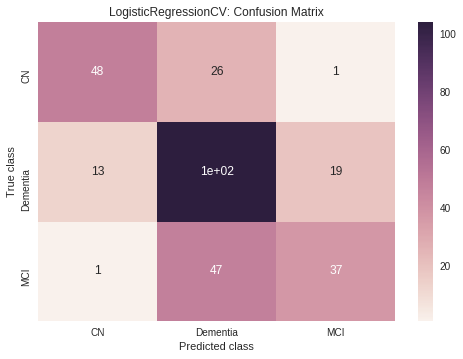

In [39]:
#Make a confusion Matrix of Results
confusion = confusion_matrix(y_test,y_pred)

ax=sns.heatmap(confusion, annot=True, xticklabels=['CN', 'Dementia', 'MCI'], yticklabels=['CN', 'Dementia', 'MCI']);
ax.set_title('LogisticRegressionCV: Confusion Matrix');
ax.set_xlabel('Predicted class');
ax.set_ylabel('True class');

In [40]:
#prepare a dataframe in the format that seaborn countplot expects
plot_df=pd.DataFrame([y_test],index=['Class']).T
plot_df['Value Type']='True'


plot_df2=pd.DataFrame([y_pred],index=['Class']).T
plot_df2['Value Type']='Predicted'

plot_df_final=plot_df.append(plot_df2)
plot_df_final.tail()

,Class,Value Type
291,2,Predicted
292,1,Predicted
293,2,Predicted
294,2,Predicted
295,1,Predicted


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


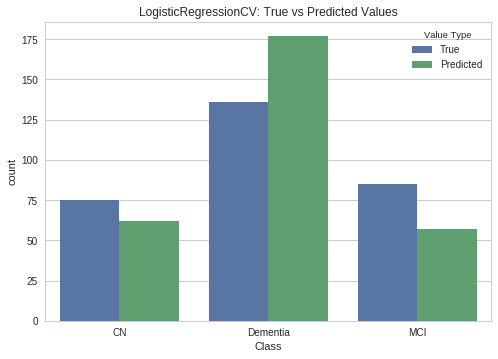

In [41]:
ax2=sns.countplot(x='Class',data=plot_df_final,hue='Value Type');
ax2.set_xticklabels(['CN', 'Dementia', 'MCI']);
ax2.set_title('LogisticRegressionCV: True vs Predicted Values');

## Section 4: Model Selections
### Model 1: KNN Model

In [42]:
#Fit KNN Regression
classifier = KNeighborsClassifier(n_neighbors=5)  
classifier.fit(X_train, y_train)  

#Check Accuracy Score
y_pred = classifier.predict(X_test)
KNN_acc = accuracy_score(y_test,y_pred)

print('The accuracy of KNN is ',KNN_acc)

The accuracy of KNN is  0.46621621621621623


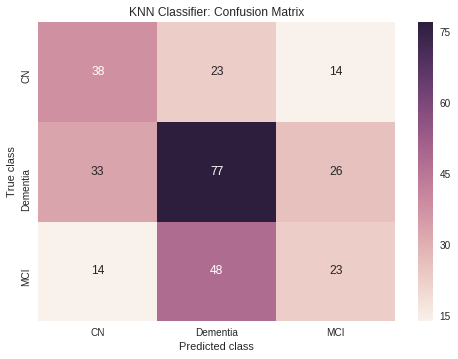

In [43]:
#Make a confusion Matrix of Results
confusion = confusion_matrix(y_test,y_pred)

ax=sns.heatmap(confusion, annot=True, xticklabels=['CN', 'Dementia', 'MCI'], yticklabels=['CN', 'Dementia', 'MCI']);
ax.set_title('KNN Classifier: Confusion Matrix');
ax.set_xlabel('Predicted class');
ax.set_ylabel('True class');

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


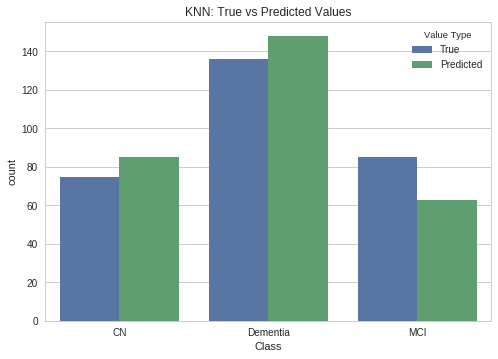

In [44]:
#prepare a dataframe in the format that seaborn countplot expects
plot_df=pd.DataFrame([y_test],index=['Class']).T
plot_df['Value Type']='True'


plot_df2=pd.DataFrame([y_pred],index=['Class']).T
plot_df2['Value Type']='Predicted'

plot_df_final=plot_df.append(plot_df2)
plot_df_final.tail()

ax2=sns.countplot(x='Class',data=plot_df_final,hue='Value Type');
ax2.set_xticklabels(['CN', 'Dementia', 'MCI']);
ax2.set_title('KNN: True vs Predicted Values');

### Model 2: LDA

In [45]:
#Fit LDA Classifier
LDA = LinearDiscriminantAnalysis()
LDA.fit(X_train, y_train) 

#Check Accuracy Score
y_pred = LDA.predict(X_test)
LDA_acc = accuracy_score(y_test,y_pred)

print('The accuracy of LDA is ',LDA_acc)

The accuracy of LDA is  0.7871621621621622


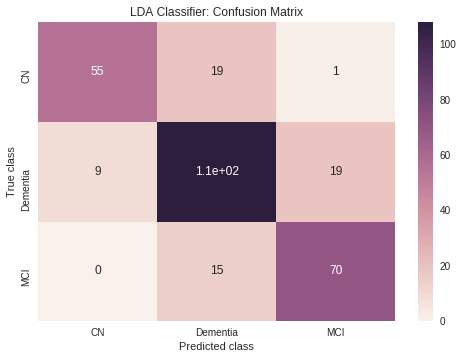

In [46]:
#Make a confusion Matrix of Results
confusion = confusion_matrix(y_test,y_pred)

ax=sns.heatmap(confusion, annot=True, xticklabels=['CN', 'Dementia', 'MCI'], yticklabels=['CN', 'Dementia', 'MCI']);
ax.set_title('LDA Classifier: Confusion Matrix');
ax.set_xlabel('Predicted class');
ax.set_ylabel('True class');

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


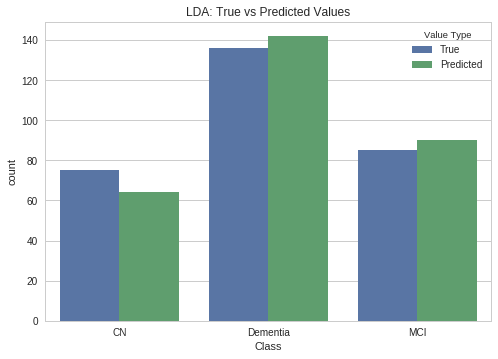

In [47]:
#prepare a dataframe in the format that seaborn countplot expects
plot_df=pd.DataFrame([y_test],index=['Class']).T
plot_df['Value Type']='True'


plot_df2=pd.DataFrame([y_pred],index=['Class']).T
plot_df2['Value Type']='Predicted'

plot_df_final=plot_df.append(plot_df2)
plot_df_final.tail()

ax2=sns.countplot(x='Class',data=plot_df_final,hue='Value Type');
ax2.set_xticklabels(['CN', 'Dementia', 'MCI']);
ax2.set_title('LDA: True vs Predicted Values');

### Model 3: QDA

In [48]:
#Fit LDA Classifier
QDA = QuadraticDiscriminantAnalysis()
QDA.fit(X_train, y_train) 

#Check Accuracy Score
y_pred = QDA.predict(X_test)
QDA_acc = accuracy_score(y_test,y_pred)

print('The accuracy of QDA is ',QDA_acc)

The accuracy of QDA is  0.6554054054054054


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


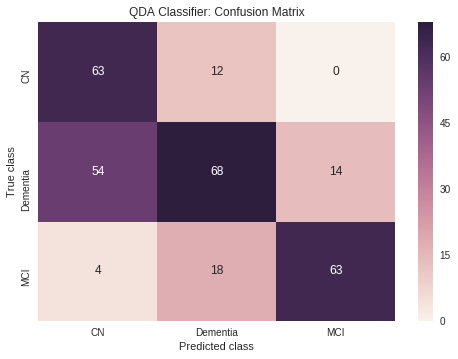

In [49]:
#Make a confusion Matrix of Results
confusion = confusion_matrix(y_test,y_pred)


ax=sns.heatmap(confusion, annot=True, xticklabels=['CN', 'Dementia', 'MCI'], yticklabels=['CN', 'Dementia', 'MCI']);
ax.set_title('QDA Classifier: Confusion Matrix');
ax.set_xlabel('Predicted class');
ax.set_ylabel('True class');

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


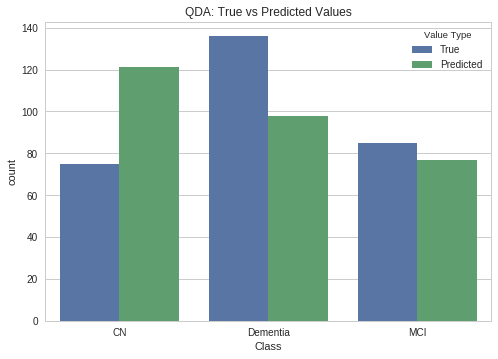

In [50]:
#prepare a dataframe in the format that seaborn countplot expects
plot_df=pd.DataFrame([y_test],index=['Class']).T
plot_df['Value Type']='True'


plot_df2=pd.DataFrame([y_pred],index=['Class']).T
plot_df2['Value Type']='Predicted'

plot_df_final=plot_df.append(plot_df2)
plot_df_final.tail()

ax2=sns.countplot(x='Class',data=plot_df_final,hue='Value Type');
ax2.set_xticklabels(['CN', 'Dementia', 'MCI']);
ax2.set_title('QDA: True vs Predicted Values');

### Summary of Model Performance

In [51]:
summary = pd.DataFrame({'Model':['Logistic','KNN','LDA','QDA'], 'Performance':[Log_acc,KNN_acc,LDA_acc,QDA_acc]})

summary

,Model,Performance
0,Logistic,0.638514
1,KNN,0.466216
2,LDA,0.787162
3,QDA,0.655405


### Discussion:

From the models chose above, LDA had the best score on our test data.

In [0]:
#helper functions for testing the models
def make_model_plots(y_test,y_pred,model_name: str):
  
  print('The accuracy of %s is %g\n' % (model_name, accuracy_score(y_test,y_pred)))
  
  #calculate confusion matrix and make plot
  confusion = confusion_matrix(y_test,y_pred)
  plt.figure(0)
  ax=sns.heatmap(confusion, annot=True, xticklabels=['CN', 'Dementia', 'MCI'], yticklabels=['CN', 'Dementia', 'MCI']);
  ax.set_title('%s Classifier: Confusion Matrix' % model_name);
  ax.set_xlabel('Predicted class');
  ax.set_ylabel('True class');
  
  #make plot of real vs predicted class counts
  plot_df=pd.DataFrame([y_test],index=['Class']).T
  plot_df['Value Type']='True'


  plot_df2=pd.DataFrame([y_pred],index=['Class']).T
  plot_df2['Value Type']='Predicted'

  plot_df_final=plot_df.append(plot_df2)
  plot_df_final.tail()
  
  plt.figure(1)
  ax2=sns.countplot(x='Class',data=plot_df_final,hue='Value Type');
  ax2.set_xticklabels(['CN', 'Dementia', 'MCI']);
  ax2.set_title('%s: True vs Predicted Values' % model_name);
  
def edit_dot_string(dot_data, size: tuple):
  
  import io
  
  newline=""
  
  s = io.StringIO(dot_data)
  for i, line in enumerate(s):
    
    if i==1:
      newline=newline + """\n ratio="fill";\nsize="%g,%g!";\n""" % size 
    
    else:
      newline=newline+line
  
  return newline

**Model 4: Decision Trees**

In [53]:
!pip install graphviz;
!apt-get install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


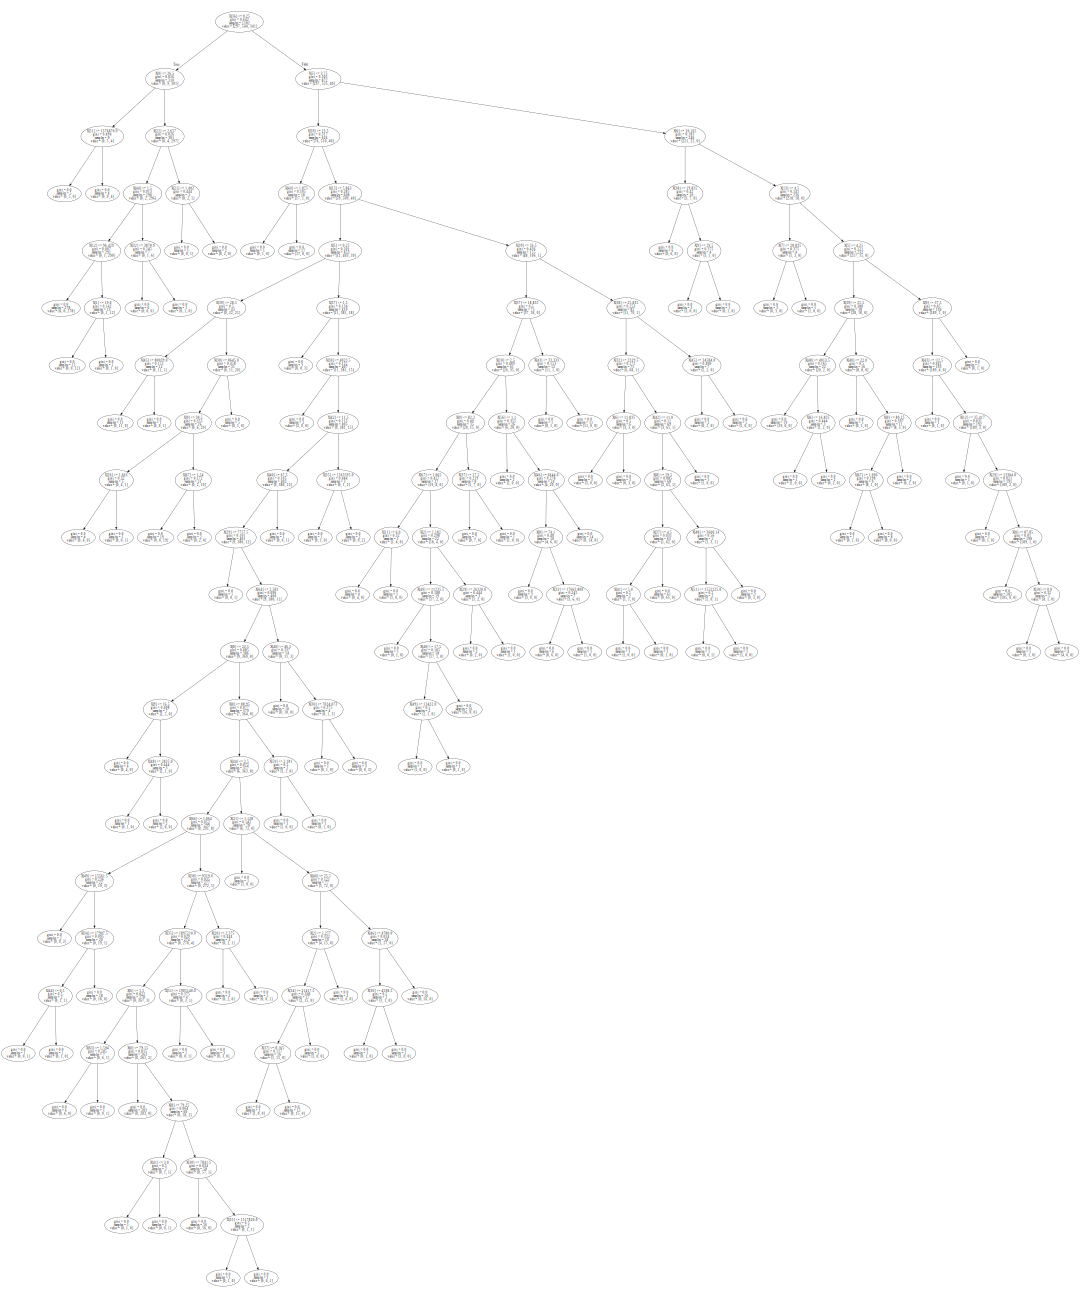

In [54]:
from sklearn import tree
import graphviz 


#first let's fit an overfit DT with no max_depth and visualize
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
dot_data=tree.export_graphviz(clf, out_file=None) 


dot_data_sized=edit_dot_string(dot_data,(15,18))

graph = graphviz.Source(dot_data_sized)
graph


The accuracy of Decision Trees is 0.847973



/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


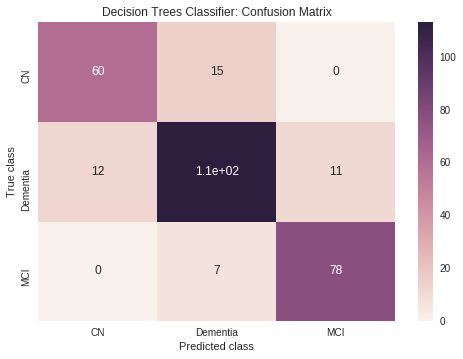

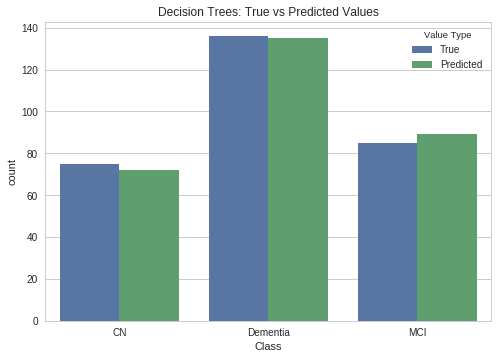

In [55]:
make_model_plots(y_test,y_pred,'Decision Trees')

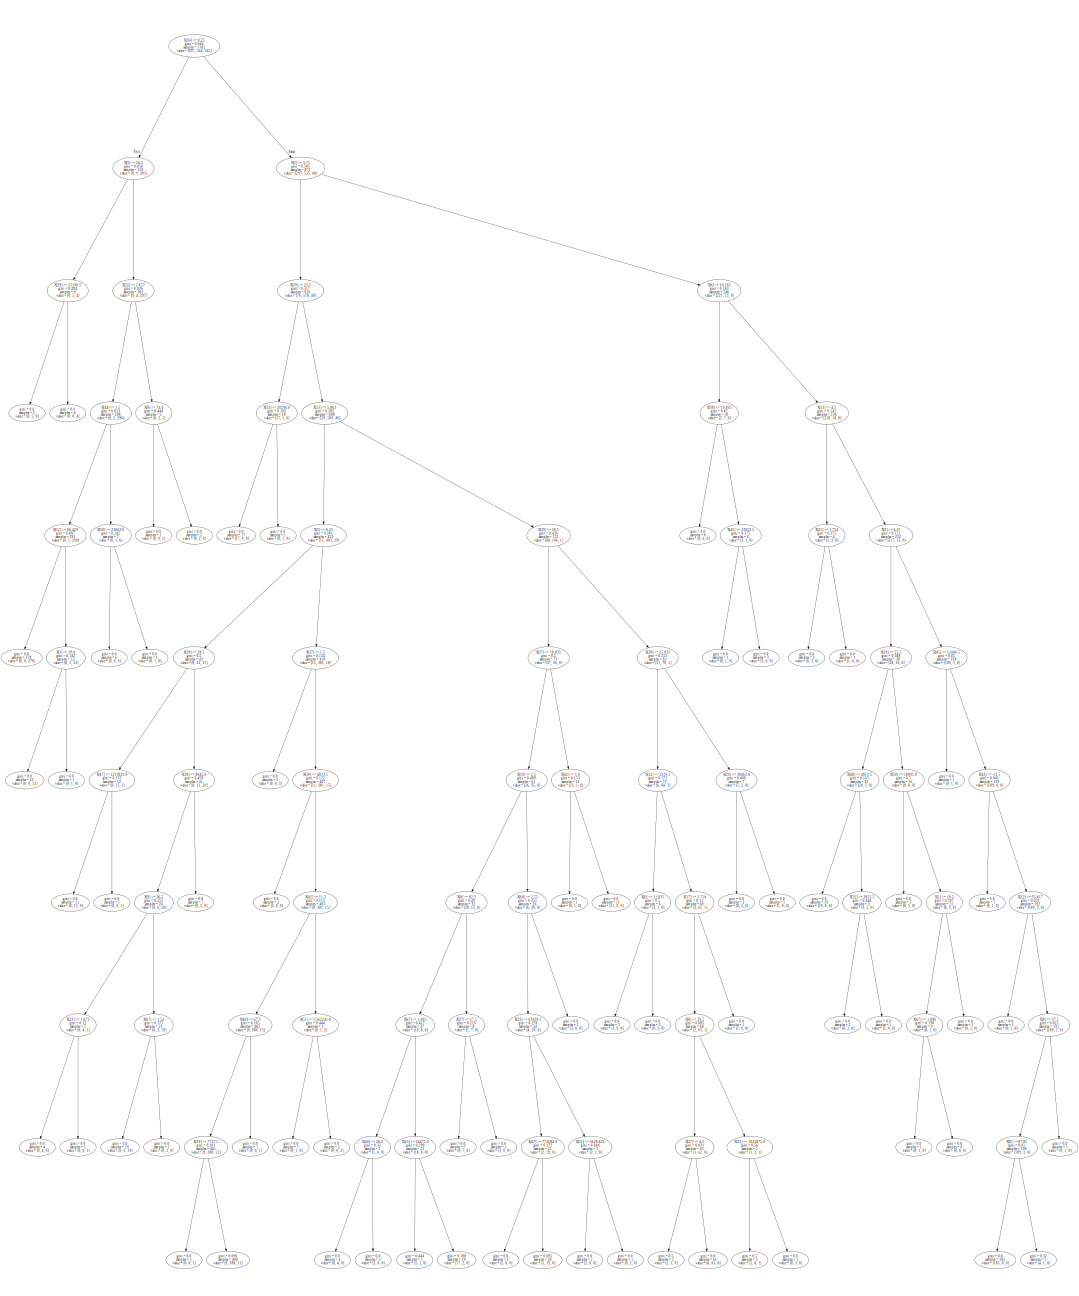

In [56]:
#lets try again with a less overfit tree
clf = tree.DecisionTreeClassifier(max_depth=10)
clf = clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
dot_data=tree.export_graphviz(clf, out_file=None) 


dot_data_sized=edit_dot_string(dot_data,(15,18))

graph = graphviz.Source(dot_data_sized)
graph


The accuracy of Decision Trees-Maxdepth: 10 is 0.864865



/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


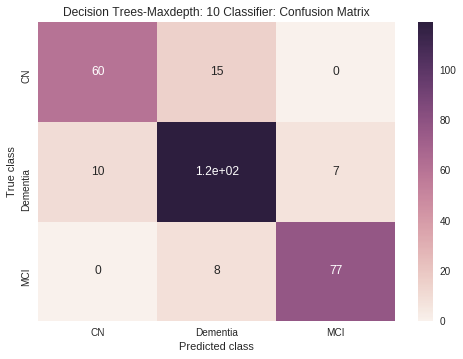

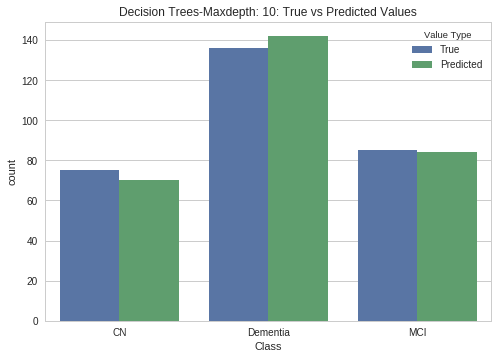

In [57]:
make_model_plots(y_test,y_pred,'Decision Trees-Maxdepth: 10')

**Model 5: Random Forest**

In [0]:
from sklearn.ensemble import RandomForestClassifier

rf_model=RandomForestClassifier(n_estimators=100, max_depth=None)
rf_model.fit(X_train,y_train)
y_pred=rf_model.predict(X_test)

The accuracy of Random Forest is 0.885135



/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


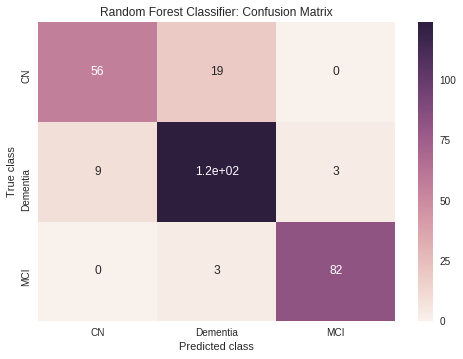

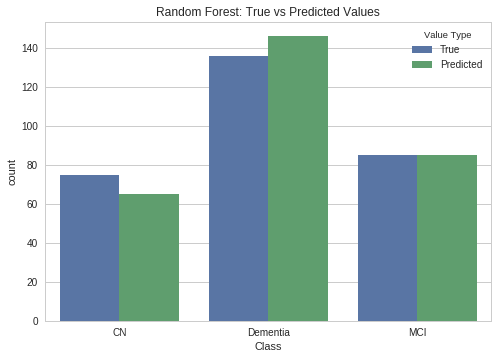

In [59]:
make_model_plots(y_test,y_pred,'Random Forest')

**Model 6: SVM**

In [60]:
from sklearn.svm import SVC, LinearSVC, NuSVC

svc = SVC(C=10, gamma=10,kernel='rbf', degree=3, coef0=0.0, tol=0.001, random_state=42, verbose=True)
#svc = LinearSVC(C=100, random_state=42,verbose=True)
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)

[LibSVM]

The accuracy of SVC: degree-3 is 0.459459



/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


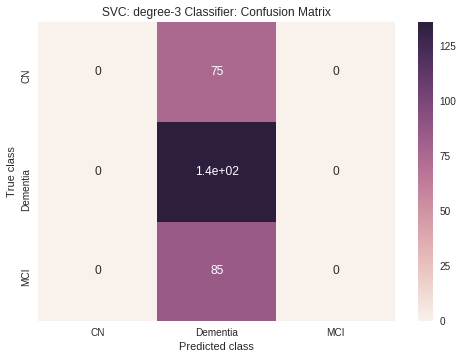

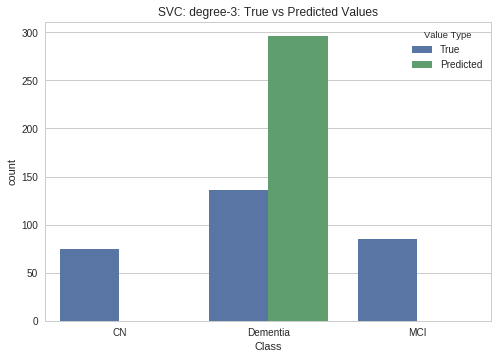

In [61]:
make_model_plots(y_test,y_pred,'SVC: degree-3')

**Model X: UMAP**

In [62]:
!pip install numba
!pip install umap-learn

import umap

In [0]:
data=np.vstack([X_train,X_test])
target=np.hstack([y_train,y_test])
embedding=umap.UMAP(random_state=42, n_components=2,n_neighbors=20,min_dist=0.5,metric='canberra').fit_transform(data)


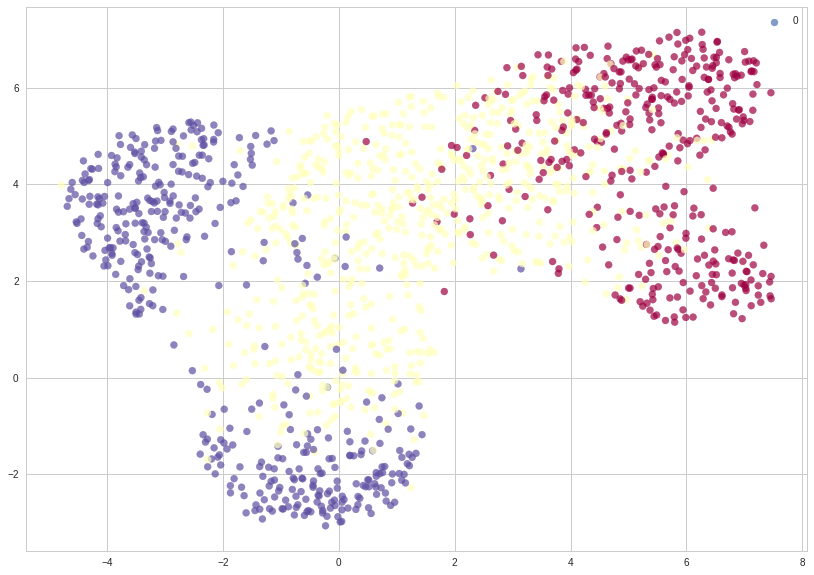

In [100]:
#print(embedding.T.shape)
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, c=target, cmap='Spectral',alpha=0.7)

plt.legend(['0', '1', '2'])

In [80]:
import seaborn as sns
print(embedding.shape)
sns.lmplot(x=embedding.T[0,:],y=embedding.T[1,:], data=embedding.T, hue=target)

SyntaxError: ignored

## Section 5: Neural Network